In [1]:
!git clone https://github.com/Zigolox/Meta-Learning-OptML-Project
%cd /content/Meta-Learning-OptML-Project

fatal: destination path 'Meta-Learning-OptML-Project' already exists and is not an empty directory.
/content/Meta-Learning-OptML-Project


In [2]:
%%capture
!pip install --upgrade einops optax equinox distrax jaxopt jax-tqdm

In [3]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import gelu, sigmoid
from jax import disable_jit
from jaxopt import FixedPointIteration
from jax.tree_util import tree_map, tree_leaves

from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)
TRAIN_KEY = random.PRNGKey(SEED + 2)

import copy
import matplotlib.pyplot as plt

In [4]:
def multi_batch_loss(model_alpha, batch_loss, batch_of_tasks, inner_step) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i:
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks
    models = eqx.filter_vmap(task_update,in_axes=(None,0,0,None,None))(model_alpha, batch_train, batch_train_labels, inner_step, batch_loss)
    # sum loss_i(model_i', test_i, test_labels_i)
    return eqx.filter_vmap(batch_loss)(models, batch_test, batch_test_labels).sum()

In [5]:
def batch_loss(model, x_arr: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(x: Array, label: Array):
        # -> (model(x)-Asin(x+w))^2
        pred = model(jnp.array([x]))
        return (pred-label)**2

    # Mean over the batch
    return vmap(loss)(x_arr, labels).mean()

In [6]:
def task_update(model_alpha, train, train_labels, inner_step, batch_loss):
    model_i = inner_step(model_alpha, train, train_labels, batch_loss)  # compute model_i'
    return model_i

In [7]:
@partial(eqx.filter_jit)
def outer_step_METASGD(model_alpha, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks):
     
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model_alpha, batch_loss, batch_of_tasks, inner_step)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model_alpha)  
    model_alpha = eqx.apply_updates(model_alpha, updates)  

    return loss, model_alpha, outer_opt_state



In [8]:
# Training step function
#@eqx.filter_jit
def inner_step_METASGD(model_alpha, train, train_labels, batch_loss):

    model, alpha = copy.deepcopy(model_alpha[0]), model_alpha[1] 

    inner_optim = sgd(1) 
    inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, alpha)  # replace standard gradient with alpha*gradient (elementwise product)
    updates, opt_state = inner_optim.update(mod_grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [9]:
@partial(eqx.filter_jit)
def outer_step_MAML(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks):
     
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model, batch_loss, batch_of_tasks, inner_step)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return loss, model, outer_opt_state

In [10]:
def inner_step_MAML(model, train, train_labels, batch_loss):

    model = copy.deepcopy(model)

    inner_optim = sgd(0.01) 
    inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    updates, opt_state = inner_optim.update(grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [11]:
@partial(eqx.filter_jit)
def outer_step_FOMAML(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks):
    
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks
    models = eqx.filter_vmap(task_update,in_axes=(None,0,0,None,None))(model, batch_train, batch_train_labels, inner_step, batch_loss)
    def multi_batch_loss_fomaml(models, test, test_labels) -> Array:
            """Compute the loss over all models"""
            return eqx.filter_vmap(batch_loss)(models, test, test_labels).sum()
    
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss_fomaml)(models, batch_test, batch_test_labels)  # Compute loss and gradient, meta step
    grad = tree_map(lambda x : x.sum(0),grads)
    updates, outer_opt_state = outer_optim.update(grad, outer_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return loss, model, outer_opt_state

In [12]:
def inner_step_FOMAML(model, train, train_labels, batch_loss):

    model = copy.deepcopy(model)

    inner_optim = sgd(0.01) 
    inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    updates, opt_state = inner_optim.update(grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [13]:
@partial(eqx.filter_jit)
def outer_step_REPTILE(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks):
    
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks

    models = eqx.filter_vmap(task_update,in_axes=(None,0,0,None,None))(model, batch_train, batch_train_labels, inner_step, batch_loss)

    model_tilde = tree_map(lambda x: x.sum(0), eqx.filter(models,eqx.is_array))
    model_tilde = tree_map(lambda x: (1/meta_batch_size)*x, model_tilde)

    dyn_model = tree_map((lambda x,y: x+0.01*(y-x)), eqx.filter(model,eqx.is_array), eqx.filter(model_tilde,eqx.is_array))
    model = eqx.combine(dyn_model, model)
    
    loss, outer_opt_state = None, None
    return loss, model, outer_opt_state

In [14]:
def inner_step_REPTILE(model, train, train_labels, batch_loss):

    model = copy.deepcopy(model)

    inner_optim = adam(1e-3, 1e-04) 
    inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

    # my attempt to scan:
    dynamic_model, static_model = eqx.partition(model, eqx.is_array)
    def step(carry, i):
        dynamic_model, inner_opt_state = carry
        loss, grad = eqx.filter_value_and_grad(batch_loss)(eqx.combine(dynamic_model,static_model), train, train_labels)  # Compute loss and gradient
        updates, inner_opt_state = inner_optim.update(grad, inner_opt_state, eqx.combine(dynamic_model,static_model))  
        model = eqx.apply_updates(eqx.combine(dynamic_model,static_model), updates) 
        return (eqx.partition(model, eqx.is_array)[0], inner_opt_state), loss
    carry = (dynamic_model, inner_opt_state)
    (dynamic_model, inner_opt_state), losses = lax.scan(step,carry,jnp.arange(32))
    model = eqx.combine(dynamic_model,static_model)
    
    #for j in range(32):  # K steps of SGD or ADAM
     #   loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
      #  updates, inner_opt_state = inner_optim.update(grad, inner_opt_state, model)  
       # model = eqx.apply_updates(model, updates)   

    return model

In [15]:
# function to load data
def load_batch_of_tasks(nr_train, nr_test, train_key, test_key):  
    A = random.uniform(train_key, shape=(1,),minval=0.1, maxval=5.0)
    w = random.uniform(train_key, shape=(1,),minval=0.0, maxval=jnp.pi)

    train = random.uniform(train_key,shape=(nr_train,),minval=-5.0, maxval=5.0)
    train_labels = jnp.concatenate(list(map(lambda x: A*jnp.sin(x+w), train)))

    test = random.uniform(test_key,shape=(nr_test,),minval=-5.0, maxval=5.0).sort()
    test_labels = jnp.concatenate(list(map(lambda x: A*jnp.sin(x+w), test)))

    return train, train_labels, test, test_labels


In [16]:
def disp_meta_test(expl_model, model, nr_test_train, nr_test, train_key, 
                   test_key, task_update_step, batch_loss, title=''):
    # Load the dataset
    K, Kprime = nr_test_train, nr_test
    number_of_points = (K, Kprime)  # (number of training points, number of testing points)

    train_test, train_test_labels, test, test_labels = load_batch_of_tasks(nr_test_train, nr_test, train_key, test_key)

    preds_initial = eqx.filter_vmap(expl_model)(jnp.expand_dims(test,1))

    plt.scatter(test, preds_initial, color='blue', label="Pre initalization")
    plt.scatter(test, test_labels, color='red')

    test_model = task_update_step(model, train_test, train_test_labels, batch_loss)

    preds_shot = eqx.filter_vmap(test_model)(jnp.expand_dims(test,1))
    plt.scatter(test, preds_shot, label="K-shot learning")
    plt.scatter(train_test, train_test_labels, color='black')
    plt.legend()
    plt.title(title)
    plt.show()

In [17]:
epochs = 60000
nr_train = 20
nr_test = 10
meta_batch_size = 4
test_keys = random.split(TEST_KEY, epochs)
train_keys = random.split(TRAIN_KEY+213, epochs)

In [18]:
# META SGD

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
alpha = copy.deepcopy(eqx.filter(model,eqx.is_array))
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*jnp.ones(shape=x.shape), alpha)
beta = 0.0001  # outer loop LR, constant
outer_optim = sgd(beta)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, alpha, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(nr_train,nr_test, train_keys_batch, test_keys_batch)
    loss, (model, alpha), outer_opt_state = outer_step_METASGD((eqx.combine(dynamic_model,static_model), alpha), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_METASGD, batch_of_tasks)
    return (eqx.partition(model, eqx.is_array)[0], alpha, outer_opt_state), loss

carry = (dynamic_model, alpha, outer_opt_state)
(dynamic_model, alpha, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

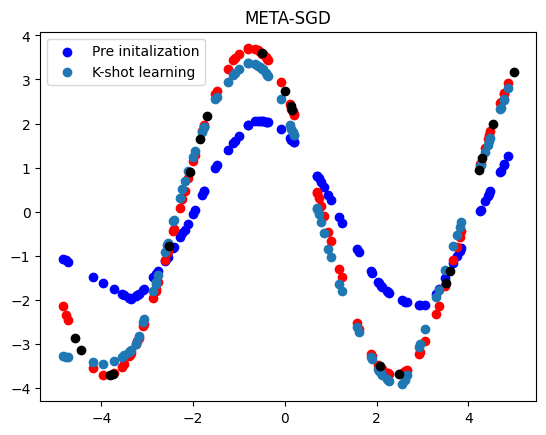

In [19]:
disp_meta_test(model,(model, alpha), nr_train, 100, TRAIN_KEY+201, TEST_KEY+201, inner_step_METASGD, batch_loss, title="META-SGD")

In [20]:
# MAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3, eps=1e-04)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(nr_train,nr_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_MAML(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_MAML, batch_of_tasks)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

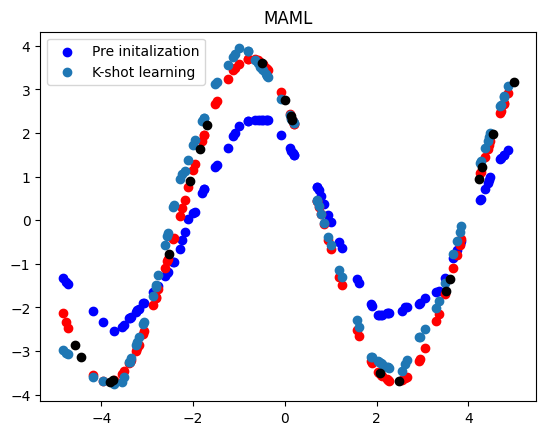

In [21]:
disp_meta_test(model,model, nr_train, 100, TRAIN_KEY+201, TEST_KEY+201, inner_step_MAML, batch_loss, title="MAML")

In [22]:
# FOMAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3, eps=1e-04)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(nr_train,nr_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_FOMAML(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_FOMAML, batch_of_tasks)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

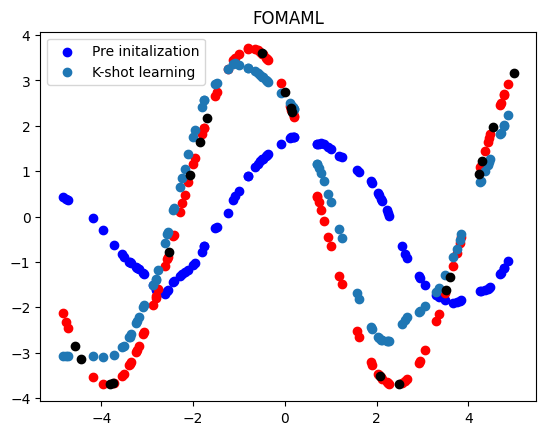

In [23]:
disp_meta_test(model,model, nr_train, 100, TRAIN_KEY+201, TEST_KEY+201, inner_step_FOMAML, batch_loss, title="FOMAML")

In [24]:
# REPTILE
epochs = 6000

model = eqx.nn.MLP(1,1,64,2,key=MODEL_KEY)
outer_optim = None
outer_opt_state = None

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(nr_train,nr_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_REPTILE(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_REPTILE, batch_of_tasks)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/6000 [00:00<?, ?it/s]

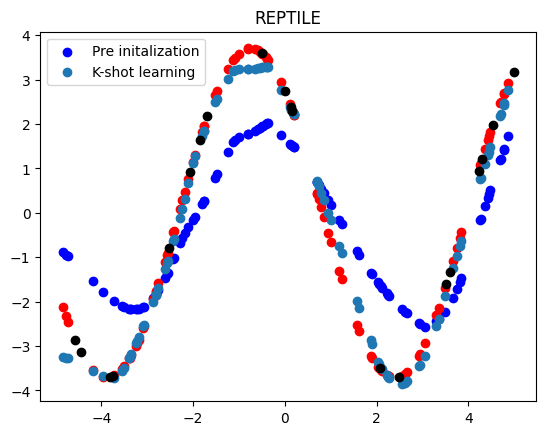

In [25]:
disp_meta_test(model,model, nr_train, 100, TRAIN_KEY+201, TEST_KEY+201, inner_step_REPTILE, batch_loss, title="REPTILE")